In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import make_column_selector as selector
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns

## Dataset

https://www.kaggle.com/c/bank-marketing-uci

1 - age (numeric)


2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')

3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)

4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')

5 - default: has credit in default? (categorical: 'no','yes','unknown')

6 - housing: has housing loan? (categorical: 'no','yes','unknown')

7 - loan: has personal loan? (categorical: 'no','yes','unknown')
8 - contact: contact communication type (categorical: 'cellular','telephone')

9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', …, 'nov', 'dec')

10 - dayofweek: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')

11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)

14 - previous: number of contacts performed before this campaign and for this client (numeric)

15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

Output variable (desired target):

21 - y - has the client subscribed a term deposit? (binary: 'yes','no')

In [2]:
df = pd.read_csv("bank.csv", delimiter=";")

In [3]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


## Pearson's Correlation

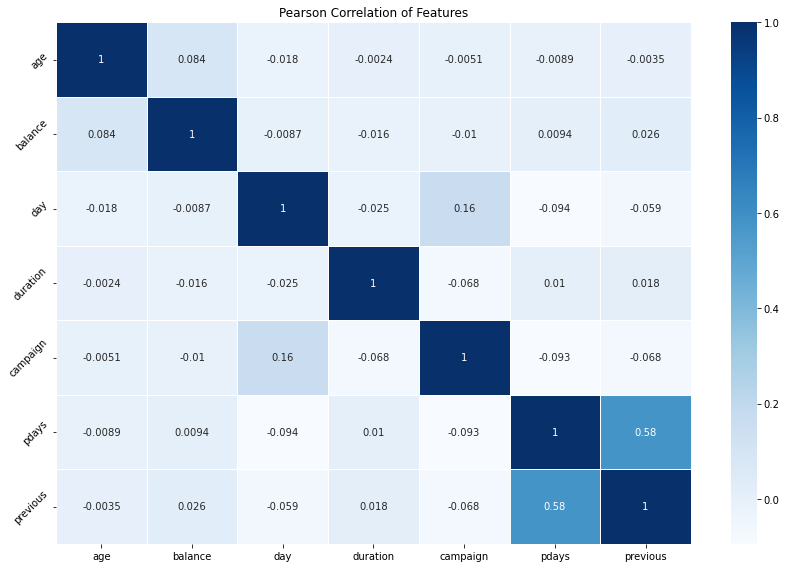

In [4]:
corr = df.corr()

f, ax = plt.subplots(figsize=(12, 8))

sns.heatmap(corr, cmap="Blues", annot=True, square=False, ax=ax,  linewidth = 1)
plt.title('Pearson Correlation of Features')
plt.yticks(rotation=45)
plt.tight_layout()
plt.savefig('featureselection_01.png', dpi=300)

## Data Preparation

In [5]:
# get categorical data
cat_data = df.select_dtypes(include=['object'])
cat_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   job        4521 non-null   object
 1   marital    4521 non-null   object
 2   education  4521 non-null   object
 3   default    4521 non-null   object
 4   housing    4521 non-null   object
 5   loan       4521 non-null   object
 6   contact    4521 non-null   object
 7   month      4521 non-null   object
 8   poutcome   4521 non-null   object
 9   y          4521 non-null   object
dtypes: object(10)
memory usage: 353.3+ KB


In [6]:
cat_data.head()

,job,marital,education,default,housing,loan,contact,month,poutcome,y
0,unemployed,married,primary,no,no,no,cellular,oct,unknown,no
1,services,married,secondary,no,yes,yes,cellular,may,failure,no
2,management,single,tertiary,no,yes,no,cellular,apr,failure,no
3,management,married,tertiary,no,yes,yes,unknown,jun,unknown,no
4,blue-collar,married,secondary,no,yes,no,unknown,may,unknown,no


In [7]:
X = cat_data.iloc[:, :-1].values
y = cat_data.iloc[:,-1].values

In [8]:
def prepare_inputs(X_train, X_test):
	oe = OrdinalEncoder()
	oe.fit(X_train)
	X_train_enc = oe.transform(X_train)
	X_test_enc = oe.transform(X_test)
	return X_train_enc, X_test_enc

In [9]:
def prepare_targets(y_train, y_test):
	le = LabelEncoder()
	le.fit(y_train)
	y_train_enc = le.transform(y_train)
	y_test_enc = le.transform(y_test)
	return y_train_enc, y_test_enc

In [10]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [11]:
# prepare input data
X_train_enc, X_test_enc = prepare_inputs(X_train, X_test)
# prepare output data
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)

In [12]:
print(X_train.shape)
print(X_test.shape)

(3029, 9)
(1492, 9)


## Feature Selection

**Chi-Squared Feature Selection**

Pearson’s chi-squared statistical hypothesis test is an example of a test for independence between categorical variables.

The results of this test can be used for feature selection, where those features that are independent of the target variable can be removed from the dataset.

The scikit-learn machine library provides an implementation of the chi-squared test in the chi2() function. This function can be used in a feature selection strategy, such as selecting the top k most relevant features (largest values) via the SelectKBest class.

For example, we can define the SelectKBest class to use the chi2() function and select all features, then transform the train and test sets.

https://machinelearningmastery.com/feature-selection-with-categorical-data/

We have a DataFrame with only the categorical data from our EDA, we'll use that to perform this analysis.

In [13]:
def select_features(X_train, y_train, X_test, k_value='all'):
	fs = SelectKBest(score_func=chi2, k=k_value)
	fs.fit(X_train, y_train)
	X_train_fs = fs.transform(X_train)
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs

In [14]:
# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train_enc, y_train_enc, X_test_enc)
# what are scores for the features
for i in range(len(fs.scores_)):
	print('Feature %d: %f' % (i, fs.scores_[i]))

Feature 0: 11.679248
Feature 1: 0.248626
Feature 2: 3.339391
Feature 3: 0.039239
Feature 4: 11.788867
Feature 5: 12.889637
Feature 6: 64.864792
Feature 7: 4.102635
Feature 8: 10.921719


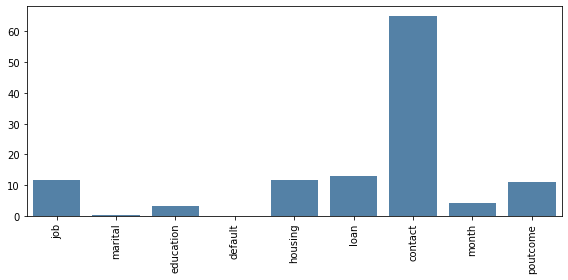

In [15]:
# what are scores for the features
names = []
values = []
for i in range(len(fs.scores_)):
    names.append(cat_data.columns[i])
    values.append(fs.scores_[i])
chi_list = zip(names, values)

# plot the scores
plt.figure(figsize=(8,4))
sns.barplot(x=names, y=values, color='steelblue')
plt.xticks(rotation = 90)
plt.tight_layout()
plt.savefig('featureselection_02.png', dpi=300);

In [16]:
X_train_fs, X_test_fs, fs = select_features(X_train_enc, y_train_enc, X_test_enc, 5)


In [17]:
fs.get_feature_names_out()

array(['x0', 'x4', 'x5', 'x6', 'x8'], dtype=object)

In [18]:
print(X_train_fs.shape)
print(X_test_fs.shape)

(3029, 5)
(1492, 5)


## Feature Selection with Random Forest

In [19]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  y          4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB


In [21]:
print(df.columns)

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')


In [22]:
# Remove columns from the list that are not relevant. 
targets = ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'campaign', 'pdays',
       'previous', 'poutcome']

In [23]:
column_trans = ColumnTransformer(transformers=
        [('num', MinMaxScaler(), selector(dtype_exclude="object")),
        ('cat', OrdinalEncoder(), selector(dtype_exclude="object"))],
        remainder='drop')
    

In [24]:
# Create a random forest classifier for feature importance
clf = RandomForestClassifier(random_state=42, n_jobs=6, class_weight='balanced')

pipeline = Pipeline([('prep',column_trans),
                        ('clf', clf)])

In [25]:
# Split the data into 30% test and 70% training
X_train, X_test, y_train, y_test = train_test_split(df[targets], df['y'], test_size=0.3, random_state=0)

In [26]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x146c7e100>),
                                                 ('cat', OrdinalEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16424f0d0>)])),
                ('clf',
                 RandomForestClassifier(class_weight='balanced', n_jobs=6,
                                        random_state=42))])

In [27]:
pipeline['clf'].feature_importances_

array([0.12097191, 0.1551929 , 0.10382712, 0.04618367, 0.04876248,
       0.02484967, 0.11530121, 0.15703306, 0.10358275, 0.04916597,
       0.05092775, 0.02420151])

In [28]:
feat_list = []

total_importance = 0
# Print the name and gini importance of each feature
for feature in zip(targets, pipeline['clf'].feature_importances_):
    feat_list.append(feature)
    total_importance += feature[1]
        
included_feats = []
# Print the name and gini importance of each feature
for feature in zip(targets, pipeline['clf'].feature_importances_):
    if feature[1] > .05:
        included_feats.append(feature[0])
        
print('\n',"Cumulative Importance =", total_importance)

# create DataFrame using data
df_imp = pd.DataFrame(feat_list, columns =['FEATURE', 'IMPORTANCE']).sort_values(by='IMPORTANCE', ascending=False)
df_imp['CUMSUM'] = df_imp['IMPORTANCE'].cumsum()
df_imp


 Cumulative Importance = 0.9999999999999999


,FEATURE,IMPORTANCE,CUMSUM
7,loan,0.157033,0.157033
1,job,0.155193,0.312226
0,age,0.120972,0.433198
6,housing,0.115301,0.548499
2,marital,0.103827,0.652326
8,contact,0.103583,0.755909
10,month,0.050928,0.806837
9,day,0.049166,0.856003
4,default,0.048762,0.904765
3,education,0.046184,0.950949


In [29]:
print('Most Important Features:')
print(included_feats)
print('Number of Included Features =', len(included_feats))

Most Important Features:
['age', 'job', 'marital', 'housing', 'loan', 'contact', 'month']
Number of Included Features = 7
